# Realtive importance analysis

In [1]:
#! pip install pingouin

In [2]:
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import List, Optional
import json

import cartopy
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import pingouin as pg
import xarray as xr
import proplot as plot

print(f"numpy:    {np.__version__}")
print(f"pandas:   {pd.__version__}")
print(f"pingouin: {pg.__version__}")
print(f"xarray:   {xr.__version__}")
print(f"plot:   {plot.__version__}")



ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


numpy:    1.22.1
pandas:   1.4.3
pingouin: 0.5.2
xarray:   2022.3.0
plot:   0.9.5


In [3]:
from subprocess import check_output, CalledProcessError
from functools import lru_cache

@lru_cache(maxsize=1)
def root():
    ''' returns the absolute path of the repository root '''
    try:
        base = check_output('git rev-parse --show-toplevel', shell=True)
    except CalledProcessError:
        raise IOError('Current working directory is not a git repository')
    return Path(base.decode('utf-8').strip())

In [4]:
@dataclass
class RelaImpoResult:
    r2: float
    r2adj: float
    covariates: List[str]
    importances: List[float]
    domain: Optional[str] = 'undefined'

In [5]:
# parameters
inpath = root() / "data" 
outpath = root() / "data" / "analysis" / "relaimpo"

In [6]:
outpath.mkdir(exist_ok=True)

In [7]:
def plot_pdf_png(fig, name:str, out_path:Path=outpath, dpi:int=300):
    """ write plots as png and pdf """
    fig.save(out_path / (name + '.png'), dpi=dpi, transparent=False)
    fig.save(out_path / (name + '.pdf'))


In [8]:
# extra stuff for admin panel [label positions]
Dreg = {k+1:v for k, v in enumerate(['Mekong River', 'North-East', 'South-East', 'Red River', 'North-C. Coast', 'South-C. Coast', 'North-West', 'Central Highl.'])}
Dreg

{1: 'Mekong River',
 2: 'North-East',
 3: 'South-East',
 4: 'Red River',
 5: 'North-C. Coast',
 6: 'South-C. Coast',
 7: 'North-West',
 8: 'Central Highl.'}

In [9]:
covariates = ['CLPC', 'SDTO', 'TOTC', 'TOTN', 'PHAQ', 'BULK', 'dC_fertilizer', 'dN_fertilizer', 'dC_residue', 'irrigation', 'surfacetemperature']


## Preprocess data

In [10]:
model = xr.open_dataset(inpath / "intermediate" / "annual_samples.nc")
model

<xarray.Dataset>
Dimensions:             (sample: 500, year: 10, lat: 186, lon: 96)
Coordinates:
  * lon                 (lon) float64 101.5 101.6 101.7 ... 109.3 109.4 109.5
  * lat                 (lat) float64 8.042 8.125 8.208 ... 23.29 23.38 23.46
  * year                (year) int64 2010 2011 2012 2013 ... 2016 2017 2018 2019
  * sample              (sample) int64 0 100 101 102 103 104 ... 96 97 98 99 9
Data variables: (12/17)
    irrigation          (sample, year, lat, lon) float64 ...
    precipitation       (sample, year, lat, lon) float64 ...
    DW_above            (sample, year, lat, lon) float64 ...
    C_stubble           (sample, year, lat, lon) float64 ...
    DW_fru_export       (sample, year, lat, lon) float64 ...
    C_plant_litter      (sample, year, lat, lon) float64 ...
    ...                  ...
    dN_nh3_emis         (sample, year, lat, lon) float64 ...
    dN_fertilizer       (sample, year, lat, lon) float64 ...
    dC_fertilizer       (sample, year, lat, lon) float64 ...
    dC_residue          (sample, year, lat, lon) float64 ...
    surfacewater        (sample, year, lat, lon) float64 ...
    surfacetemperature  (sample, year, lat, lon) float64 ...

In [11]:
misc = xr.open_dataset(inpath / "raw" / "misc" / "VN_MISC5_V3.nc")

In [12]:
subset_output = model[[x for x in model.data_vars if x in covariates] + ['dC_ch4_emis', 'dN_n2o_emis']]

In [13]:
soil = xr.open_dataset(inpath / "raw" / "misc" / "GLOBAL_WISESOIL_S1_HR.nc").sel(
    lat=slice(misc.lat.min()-0.001, misc.lat.max()+0.001), 
    lon=slice(misc.lon.min()-0.001, misc.lon.max()+0.001)
).sel(lev=1, drop=True)

In [14]:
subset_soil = soil[[x for x in soil.data_vars if x in covariates]]

In [15]:
merged = xr.merge(xr.align(misc, subset_soil, subset_output, join='override'))
merged

<xarray.Dataset>
Dimensions:             (lon: 96, lat: 186, sample: 500, year: 10)
Coordinates:
  * lon                 (lon) float64 101.5 101.6 101.7 ... 109.3 109.4 109.5
  * lat                 (lat) float64 8.042 8.125 8.208 ... 23.29 23.38 23.46
  * year                (year) int64 2010 2011 2012 2013 ... 2016 2017 2018 2019
  * sample              (sample) int64 0 100 101 102 103 104 ... 96 97 98 99 9
Data variables: (12/27)
    mask                (lat, lon) float32 ...
    simmask             (lat, lon) float32 ...
    area_ha             (lat, lon) float32 ...
    regionid            (lat, lon) float32 ...
    provinceid          (lat, lon) float32 ...
    soilid              (lat, lon) float32 ...
    ...                  ...
    dN_fertilizer       (sample, year, lat, lon) float64 ...
    dC_fertilizer       (sample, year, lat, lon) float64 ...
    dC_residue          (sample, year, lat, lon) float64 ...
    surfacetemperature  (sample, year, lat, lon) float64 ...
    dC_ch4_emis         (sample, year, lat, lon) float64 ...
    dN_n2o_emis         (sample, year, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.9 (http://mpimet.mpg.de/...
    history:      Wed Aug 12 09:58:21 2015: cdo div VN_MISC_a.nc testmask.nc ...
    institution:  Biodiversity and Climate Research Center (BIK-F), Frankfurt...
    Conventions:  CF-1.4
    version:      0.1
    author:       Christian Werner
    project:      ILRI GHG Vietnam
    CDO:          Climate Data Operators version 1.6.9 (http://mpimet.mpg.de/...

In [16]:
df_full = merged.to_dataframe().dropna().reset_index()
df_full.head()

,lon,lat,sample,year,mask,simmask,area_ha,regionid,provinceid,soilid,...,SDTO,TOTC,TOTN,irrigation,dN_fertilizer,dC_fertilizer,dC_residue,surfacetemperature,dC_ch4_emis,dN_n2o_emis
0,102.791667,22.375,0,2010,1.0,1.0,7886.652832,7.0,58.0,29.0,...,59.0,10.31,0.88,598.098221,0.007837,0.034949,0.102669,18.529913,-0.000018,0.000333
1,102.791667,22.375,0,2011,1.0,1.0,7886.652832,7.0,58.0,29.0,...,59.0,10.31,0.88,606.097680,0.007837,0.034949,0.108577,17.143495,0.000004,0.000272
2,102.791667,22.375,0,2012,1.0,1.0,7886.652832,7.0,58.0,29.0,...,59.0,10.31,0.88,757.474806,0.007837,0.034949,0.106474,18.155571,-0.000016,0.000341
3,102.791667,22.375,0,2013,1.0,1.0,7886.652832,7.0,58.0,29.0,...,59.0,10.31,0.88,580.448799,0.007837,0.034949,0.105025,17.864694,-0.000015,0.000317
4,102.791667,22.375,0,2014,1.0,1.0,7886.652832,7.0,58.0,29.0,...,59.0,10.31,0.88,677.039378,0.007837,0.034949,0.101803,18.025203,-0.000009,0.000279


In [17]:
# df = df_full.sample(frac=0.1)
# df.head()

## Regional relaimpo CH4, N2O

In [18]:
add_noise = False

regional_results_n2o = []
regional_results_ch4 = []

regions = list(range(1,9)) + [100]

for r in regions:
    print(r)
    if r < 100:
        df_reg = df_full[df_full.regionid == r]
        domain = Dreg[r]
    else:
        df_reg = df_full
        domain = "Vietnam"
    
    X = df_reg[covariates]

    if add_noise:
        # add white noise to X
        np.random.seed(42)
        noise = (np.random.rand(*X.shape) - 0.5) * 0.001
        X = X + noise
    
    regression_result_n2o = pg.linear_regression(X, df_reg.dN_n2o_emis, relimp=True)
    regression_result_ch4 = pg.linear_regression(X, df_reg.dC_ch4_emis, relimp=True)

    rir_ch4 = RelaImpoResult(
        r2=regression_result_ch4.loc[0, 'r2'],
        r2adj=regression_result_ch4.loc[0, 'adj_r2'],
        covariates=regression_result_ch4.names[1:].values.tolist(),
        importances=regression_result_ch4.loc[1:, 'relimp_perc'].values.tolist(),
        domain=domain
    )

    rir_n2o = RelaImpoResult(
        r2=regression_result_n2o.loc[0, 'r2'],
        r2adj=regression_result_n2o.loc[0, 'adj_r2'],
        covariates=regression_result_n2o.names[1:].values.tolist(),
        importances=regression_result_n2o.loc[1:, 'relimp_perc'].values.tolist(),
        domain=domain
    )
    
    regional_results_ch4.append(rir_ch4)
    regional_results_n2o.append(rir_n2o)
    

1


/opt/conda/lib/python3.8/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 11 with 12 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 11 with 12 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(


2


/opt/conda/lib/python3.8/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 10 with 12 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 10 with 12 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(


3
4
5
6
7


/opt/conda/lib/python3.8/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 10 with 12 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 10 with 12 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(


8


/opt/conda/lib/python3.8/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 11 with 12 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 11 with 12 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(


100


In [19]:
table_n2o = pd.DataFrame(columns = regional_results_n2o[0].covariates)
table_ch4 = pd.DataFrame(columns = regional_results_ch4[0].covariates)

for r in regional_results_n2o:
    table_n2o = table_n2o.append(pd.DataFrame(data=dict(zip(r.covariates, r.importances)), index=[r.domain]))

for r in regional_results_ch4:
    table_ch4 = table_ch4.append(pd.DataFrame(data=dict(zip(r.covariates, r.importances)), index=[r.domain]))

table_ch4

/tmp/ipykernel_388/3876872115.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_n2o = table_n2o.append(pd.DataFrame(data=dict(zip(r.covariates, r.importances)), index=[r.domain]))
/tmp/ipykernel_388/3876872115.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_n2o = table_n2o.append(pd.DataFrame(data=dict(zip(r.covariates, r.importances)), index=[r.domain]))
/tmp/ipykernel_388/3876872115.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_n2o = table_n2o.append(pd.DataFrame(data=dict(zip(r.covariates, r.importances)), index=[r.domain]))
/tmp/ipykernel_388/3876872115.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,CLPC,SDTO,TOTC,TOTN,PHAQ,BULK,dC_fertilizer,dN_fertilizer,dC_residue,irrigation,surfacetemperature
Mekong River,1.180635,1.692760,2.337476,2.279378,0.686494,1.777860,22.716047,27.618380,31.258355,7.419883,1.032730
North-East,5.268384,8.003946,12.274602,12.455354,12.995286,3.208821,1.092665,1.415844,28.237308,10.860332,4.187457
South-East,16.901275,21.264530,6.615300,10.456002,16.073387,10.294483,0.369278,0.421560,7.789495,5.811351,4.003339
Red River,8.549944,9.219389,3.085844,4.731113,0.793793,10.915536,5.403880,6.925355,38.159543,6.924240,5.291363
North-C. Coast,1.531662,2.582450,6.304624,7.367066,9.032660,1.755093,14.341544,22.378363,31.348240,2.454565,0.903733
South-C. Coast,15.669892,11.928001,5.618963,8.487300,3.854971,4.978915,1.846143,1.947503,37.905825,5.698429,2.064058
North-West,0.442916,0.871299,0.443801,0.633866,0.697593,0.319637,24.353558,37.848325,17.005434,16.918749,0.464822
Central Highl.,12.782462,15.686909,8.327303,10.581139,7.037110,3.986593,1.193879,1.180902,27.690651,10.611425,0.921626
Vietnam,2.885608,6.845003,1.566641,1.465420,0.495310,2.708967,24.526590,26.860616,27.520524,3.267250,1.858070


In [20]:
# rename index
table_ch4.columns = ['Clay', 'Sand', 'C$_{soil}$', 'N$_{soil}$', 'pH', 'Bulk', 'C$_{fert}$', 'N$_{fert}$', 'C$_{residue}$', 'Irri.', 'Temp.']
table_n2o.columns = ['Clay', 'Sand', 'C$_{soil}$', 'N$_{soil}$', 'pH', 'Bulk', 'C$_{fert}$', 'N$_{fert}$', 'C$_{residue}$', 'Irri.', 'Temp.']
table_ch4

,Clay,Sand,C$_{soil}$,N$_{soil}$,pH,Bulk,C$_{fert}$,N$_{fert}$,C$_{residue}$,Irri.,Temp.
Mekong River,1.180635,1.692760,2.337476,2.279378,0.686494,1.777860,22.716047,27.618380,31.258355,7.419883,1.032730
North-East,5.268384,8.003946,12.274602,12.455354,12.995286,3.208821,1.092665,1.415844,28.237308,10.860332,4.187457
South-East,16.901275,21.264530,6.615300,10.456002,16.073387,10.294483,0.369278,0.421560,7.789495,5.811351,4.003339
Red River,8.549944,9.219389,3.085844,4.731113,0.793793,10.915536,5.403880,6.925355,38.159543,6.924240,5.291363
North-C. Coast,1.531662,2.582450,6.304624,7.367066,9.032660,1.755093,14.341544,22.378363,31.348240,2.454565,0.903733
South-C. Coast,15.669892,11.928001,5.618963,8.487300,3.854971,4.978915,1.846143,1.947503,37.905825,5.698429,2.064058
North-West,0.442916,0.871299,0.443801,0.633866,0.697593,0.319637,24.353558,37.848325,17.005434,16.918749,0.464822
Central Highl.,12.782462,15.686909,8.327303,10.581139,7.037110,3.986593,1.193879,1.180902,27.690651,10.611425,0.921626
Vietnam,2.885608,6.845003,1.566641,1.465420,0.495310,2.708967,24.526590,26.860616,27.520524,3.267250,1.858070


In [21]:
table_n2o

,Clay,Sand,C$_{soil}$,N$_{soil}$,pH,Bulk,C$_{fert}$,N$_{fert}$,C$_{residue}$,Irri.,Temp.
Mekong River,1.549664,1.918706,11.883036,11.739428,1.378808,9.477287,7.422437,7.602116,40.289217,5.848275,0.891027
North-East,0.932485,1.001039,5.879503,6.536924,5.218650,0.484248,21.762319,20.266324,8.402388,0.868148,28.647972
South-East,4.628256,5.326866,18.305911,28.775530,7.230499,14.411386,9.193042,8.334382,0.121402,1.779320,1.893407
Red River,2.163675,2.498069,2.628249,2.005678,0.725727,2.096328,33.775011,30.883961,9.526263,0.855769,12.841270
North-C. Coast,28.628060,14.005669,3.360919,3.849288,18.237089,6.121049,9.981095,9.358233,1.077534,4.320468,1.060594
South-C. Coast,8.151646,11.139780,13.165665,14.192023,10.324736,7.105338,12.604946,11.124663,0.401503,9.867070,1.922629
North-West,11.514410,3.812609,15.269234,11.279581,5.625479,16.189664,14.965648,7.755794,0.618355,1.361571,11.607656
Central Highl.,10.513050,9.559010,4.784576,12.770810,4.101163,6.217834,11.335975,9.416083,4.672795,18.714742,7.913963
Vietnam,4.693702,13.504588,6.082935,6.472517,1.961298,9.280383,22.220463,20.026892,9.738725,1.291533,4.726964


In [22]:
table_ch4.to_csv(outpath / "relaimpo_ch4.csv")
table_n2o.to_csv(outpath / "relaimpo_n2o.csv")

pjson = json.dumps([asdict(r) for r in regional_results_n2o], indent=4)
open(outpath / "relaimpo_n2o.json", 'w').write(pjson)

pjson = json.dumps([asdict(r) for r in regional_results_ch4], indent=4)
open(outpath / "relaimpo_ch4.json", 'w').write(pjson)

7170

In [23]:
table_ch4 = table_ch4.astype(float)
table_n2o = table_n2o.astype(float)

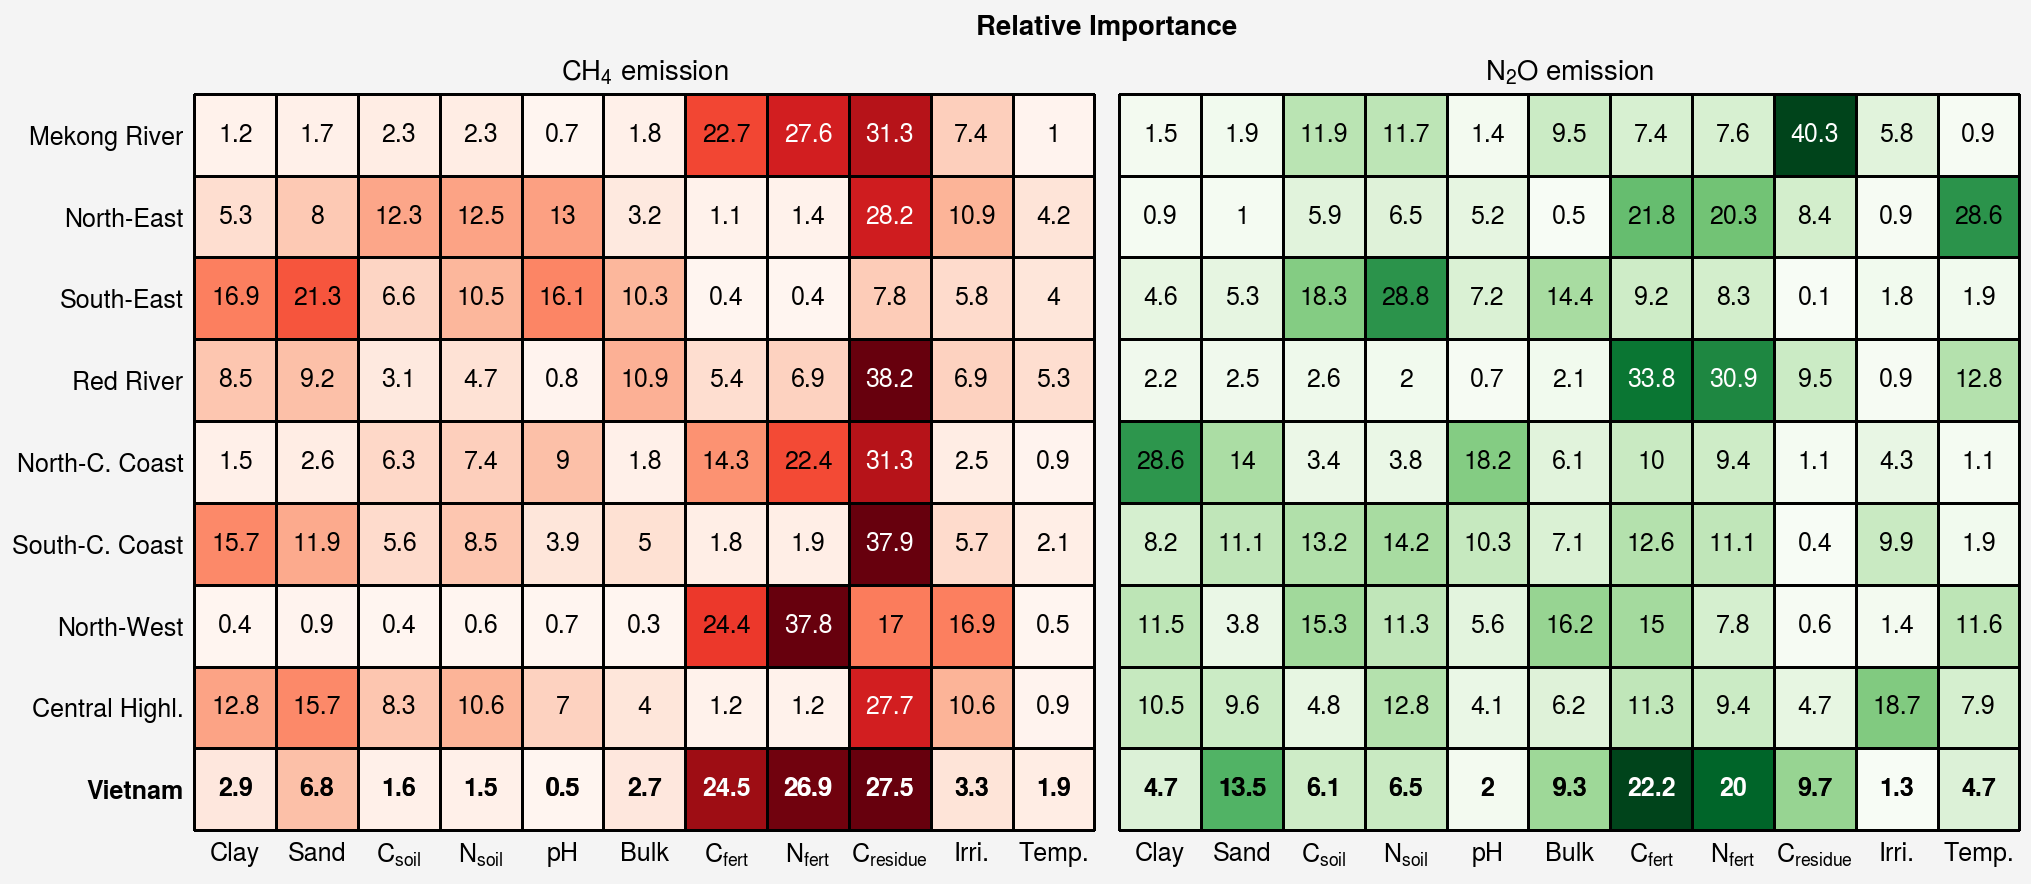

In [25]:
# Covariance matrix plot
fig, ax = plot.subplots([1,2], refwidth=4.5)
m = ax[0].heatmap(
    table_ch4, cmap='Reds', N=100, lw=0.5, ec='k',
    labels=True, precision=1, labels_kw={'weight': 'regular'},
    clip_on=False,  # turn off clipping so box edges are not cut in half
)

masked_data = table_ch4.copy(deep=True)
masked_data[:] = np.nan
masked_data.loc["Vietnam",:] = table_ch4.loc["Vietnam",:]
m = ax[0].heatmap(
    masked_data, cmap='Reds', N=100, lw=0.5, ec='k',
    labels=True, precision=1, labels_kw={'weight': 'bold'},
    clip_on=False,  # turn off clipping so box edges are not cut in half
)


m = ax[1].heatmap(
    table_n2o, cmap='Greens', N=100, lw=0.5, ec='k',
    labels=True, precision=1, labels_kw={'weight': 'regular'},
    clip_on=False,  # turn off clipping so box edges are not cut in half
)

masked_data = table_n2o.copy(deep=True)
masked_data[:] = np.nan
masked_data.loc["Vietnam",:] = table_n2o.loc["Vietnam",:]
m = ax[1].heatmap(
    masked_data, cmap='Greens', N=100, lw=0.5, ec='k',
    labels=True, precision=1, labels_kw={'weight': 'bold'},
    clip_on=False,  # turn off clipping so box edges are not cut in half
)


ax[0].format(
    suptitle='Relative Importance', title='CH$_4$ emission', # [r$^2_{{adj.}}$: {regional_results_ch4[0].r2adj:.2f}]',
    xloc='bottom', yloc='left', yreverse=True, #ticklabelweight='bold',
    alpha=0, linewidth=0, tickpad=4, #xrotation=90,
)

ax[1].format(
    title=f'N$_2$O emission', # [r$^2_{{adj.}}$: {regional_results_n2o[0].r2adj:.2f}]',
    xloc='bottom', yloc='left', yreverse=True, #ticklabelweight='bold',
    alpha=0, linewidth=0, tickpad=4, #xrotation=90,
)


ax[0].get_yticklabels()[-1].set_weight("bold")
    

In [26]:
plot_pdf_png(fig, 'relaimpo')

## Stats

In [ ]:
# annual = xr.open_dataset(inpath / "intermediate" / "annual_pctl.nc")
# annual

In [ ]:
regional_results_ch4